This problem is not about:

- finding the kinetics

- reproducing the Ostwald process

- or matching a hidden “answer”

It is about:

1. hypothesis-driven kinetic modeling

2. parameter estimation under noisy data

3. engineering judgment in the face of uncertainty

Featured Modeling Study\
This problem admits no unique correct solution. The following solutions are presented together to illustrate different valid modeling hypotheses applied to the same dataset.

Credit Language

- Framework & reference implementation: **[Arya Rane](https://github.com/TheAnveshak)**

- Hypothesis-driven solution: **Karthik Mahadevan**

- Alternative hypothesis & fit: **[Dhavall Raja](https://github.com/DhavallRaja)**

## Data

| Time | $NH_3$ | $NO$ | $N_2$ | $O_2$ | $NO_2$ |
|------|-----|----|----|----|-----|
| 0.0  | 4.024 | 5.994 | 0.000 | 5.149 | 0.000 |
| 0.3  | 2.073 | 2.759 | 2.386 | 4.732 | 0.388 |
| 0.5  | 1.633 | 1.852 | 2.818 | 4.413 | 0.947 |
| 0.8  | 1.385 | 1.471 | 2.916 | 3.751 | 1.414 |
| 1.0  | 1.169 | 1.160 | 2.895 | 3.499 | 1.815 |
| 1.4  | 1.075 | 0.919 | 2.877 | 3.121 | 2.245 |
| 1.7  | 0.988 | 0.795 | 2.842 | 2.838 | 2.539 |
| 2.0  | 0.928 | 0.673 | 2.822 | 2.569 | 2.783 |
| 3.0  | 0.799 | 0.467 | 2.679 | 1.979 | 3.410 |
| 3.5  | 0.790 | 0.404 | 2.650 | 1.789 | 3.551 |
| 4.0  | 0.755 | 0.357 | 2.591 | 1.665 | 3.746 |
| 5.0  | 0.725 | 0.280 | 2.547 | 1.392 | 3.989 |
| 6.0  | 0.686 | 0.229 | 2.419 | 1.223 | 4.183 |
| 7.0  | 0.647 | 0.198 | 2.421 | 1.096 | 4.273 |
| 8.0  | 0.647 | 0.172 | 2.383 | 1.019 | 4.361 |
| 9.0  | 0.618 | 0.146 | 2.350 | 0.923 | 4.473 |
| 10.0 | 0.630 | 0.127 | 2.340 | 0.859 | 4.437 |


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp, solve_bvp
from scipy.optimize import curve_fit, least_squares

## Ideal Solution

In [20]:
df = pd.read_csv("kinetics_data.csv")

In [21]:
# names changed for simplicity
df = df.rename(columns={
    "NH3": "CA",
    "NO":  "CB",
    "N2":  "CC",
    "O2":  "CD",
    "NO2": "CE"
})

In [22]:
C_data = np.vstack([df["CA"].values, df["CB"].values, df["CC"].values, df["CD"].values, df["CE"].values]).T
C_data

array([[4.024, 5.994, 0.   , 5.149, 0.   ],
       [2.073, 2.759, 2.386, 4.732, 0.388],
       [1.633, 1.852, 2.818, 4.413, 0.947],
       [1.385, 1.471, 2.916, 3.751, 1.414],
       [1.169, 1.16 , 2.895, 3.499, 1.815],
       [1.075, 0.919, 2.877, 3.121, 2.245],
       [0.988, 0.795, 2.842, 2.838, 2.539],
       [0.928, 0.673, 2.822, 2.569, 2.783],
       [0.799, 0.467, 2.679, 1.979, 3.41 ],
       [0.79 , 0.404, 2.65 , 1.789, 3.551],
       [0.755, 0.357, 2.591, 1.665, 3.746],
       [0.725, 0.28 , 2.547, 1.392, 3.989],
       [0.686, 0.229, 2.419, 1.223, 4.183],
       [0.647, 0.198, 2.421, 1.096, 4.273],
       [0.647, 0.172, 2.383, 1.019, 4.361],
       [0.618, 0.146, 2.35 , 0.923, 4.473],
       [0.63 , 0.127, 2.34 , 0.859, 4.437]])

In [23]:
idx = np.argsort(df["Time"].values)
t = df["Time"].values[idx]
C_data = C_data[idx]


In [ ]:
def ode(t, C, k1, k2, k3, n1, n2, n3, n4, n5):
    CA, CB, CC, CD, CE = C   # NH3, NO, N2, O2, NO2

    # Hypothesized rate laws
    r1 = k1 * CA**n4 * CB**n1         
    r2 = k2 * CB**n2              
    r3 = k3 * CC**n5 * CD**n3               

    dCdt = np.zeros(5)

    # NH3
    dCdt[0] = -4*r1

    # NO
    dCdt[1] = -6*r1 - 2*r2

    # N2
    dCdt[2] =  5*r1 + r2 - r3

    # O2
    dCdt[3] =  r2 - 2*r3

    # NO2
    dCdt[4] =  2*r3

    return dCdt


In [25]:
def model(t, params):
    k1, k2, k3, n1, n2, n3, n4, n5 = params
    y0 = [C_data[0,0], C_data[0,1], C_data[0,2], C_data[0,3], C_data[0,4]]
    sol = solve_ivp(lambda tt, yy: ode(tt, yy, k1, k2, k3, n1, n2, n3, n4, n5),
                    [t[0], t[-1]], y0, t_eval=t, 
                    method="LSODA", dense_output=True)
    return sol.y.T

In [26]:
def residuals(params):
    C_pred = model(t, params)  
    return (C_pred - C_data).ravel()


In [27]:
p0 = [0.1, 0.1, 0.1, 1, 1, 1, 1, 1]


In [28]:
result = least_squares(residuals, p0, bounds=(0, np.inf))
k1_fit, k2_fit, k3_fit, n1_fit, n2_fit, n3_fit, n4_fit, n5_fit = result.x

In [29]:
k1_fit, k2_fit, k3_fit, n1_fit, n2_fit, n3_fit, n4_fit, n5_fit

(np.float64(0.08870537445376687),
 np.float64(0.047277332247472305),
 np.float64(0.01974377731429611),
 np.float64(2.107535754993013),
 np.float64(1.7512216754117667),
 np.float64(2.040405924440912),
 np.float64(2.3058517204372244e-22),
 np.float64(0.9400875337551428))

In [30]:
tt = np.linspace(0, 10, 200)
Cfit = model(tt, result.x)
Cpred = model(t, result.x)
sk.metrics.r2_score(C_data, Cpred)

0.998079876584651

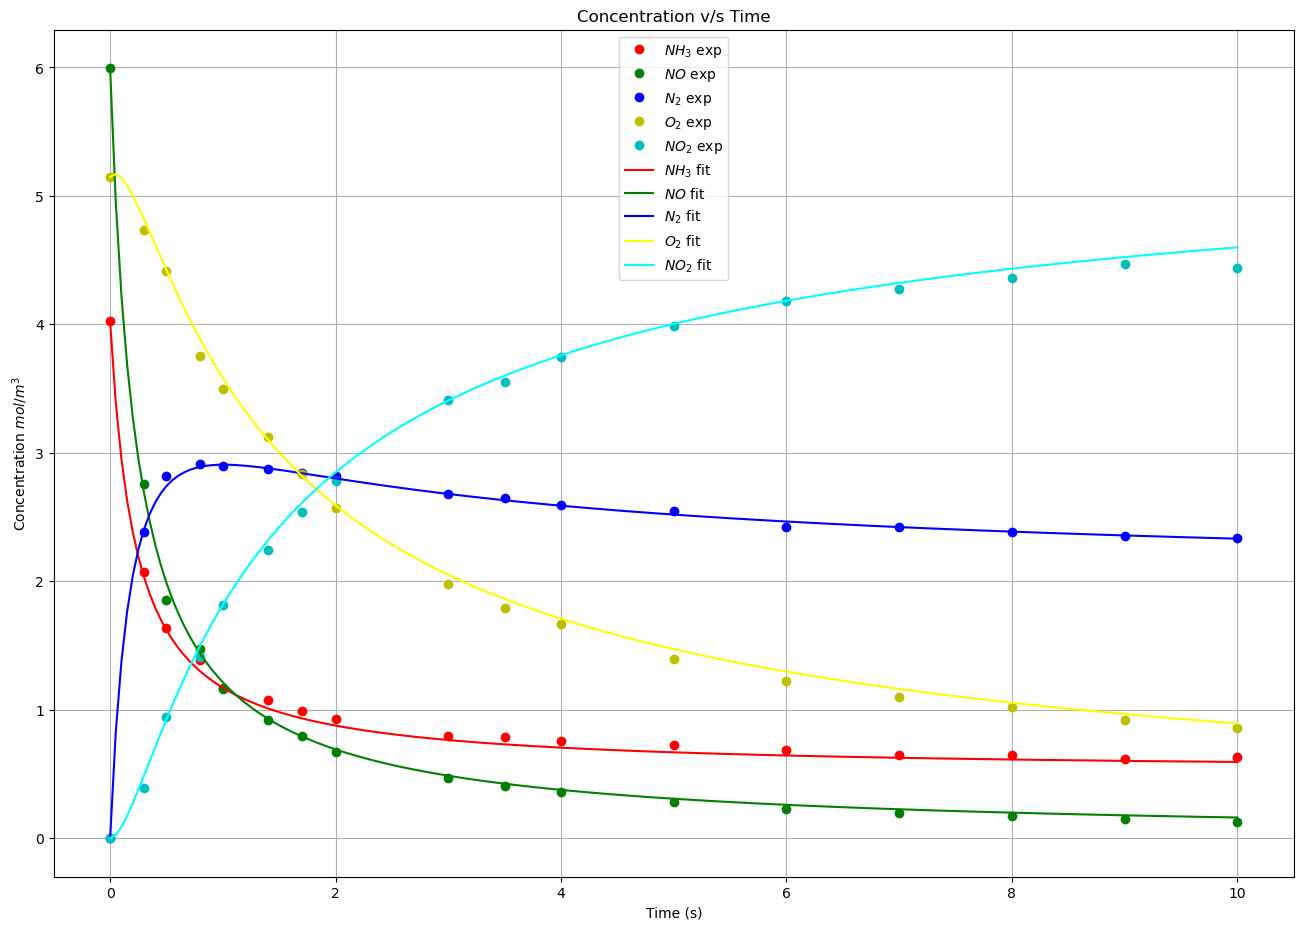

In [32]:
plt.figure(figsize=[16,11])
plt.plot(t, C_data[:,0], 'or', label='$NH_3$ exp')
plt.plot(t, C_data[:,1], 'og', label='$NO$ exp')
plt.plot(t, C_data[:,2], 'ob', label='$N_2$ exp')
plt.plot(t, C_data[:,3], 'oy', label='$O_2$ exp')
plt.plot(t, C_data[:,4], 'oc', label='$NO_2$ exp')
plt.plot(tt, Cfit[:,0], color="red", label="$NH_3$ fit")
plt.plot(tt, Cfit[:,1], color="green", label="$NO$ fit")
plt.plot(tt, Cfit[:,2], color="blue", label="$N_2$ fit")
plt.plot(tt, Cfit[:,3], color="yellow", label="$O_2$ fit")
plt.plot(tt, Cfit[:,4], color="cyan", label="$NO_2$ fit")
plt.legend()
plt.title("Concentration v/s Time")
plt.xlabel("Time (s)")
plt.ylabel("Concentration $mol/m^3$")
plt.grid()
plt.show()

## Karthik's Solution

In [ ]:
import numpy as np
import scipy.optimize as scopt
import scipy.integrate as scint
import matplotlib.pyplot as plt

In [ ]:
data = [[0.0,4.024,5.994,0.0,5.149,0.0],
[0.3,2.073,2.759,2.386,4.732,0.388],
[0.5,1.633,1.852,2.818,4.413,0.947],
[0.8,1.385,1.471,2.916,3.751,1.414],
[1.0,1.169,1.16,2.895,3.499,1.815],
[1.4,1.075,0.919,2.877,3.121,2.245],
[1.7,0.988,0.795,2.842,2.838,2.539],
[2.0,0.928,0.673,2.822,2.569,2.783],
[3.0,0.799,0.467,2.679,1.979,3.41],
[3.5,0.79,0.404,2.65,1.789,3.551],
[4.0,0.755,0.357,2.591,1.665,3.746],
[5.0,0.725,0.28,2.547,1.392,3.989],
[6.0,0.686,0.229,2.419,1.223,4.183],
[7.0,0.647,0.198,2.421,1.096,4.273],
[8.0,0.647,0.172,2.383,1.019,4.361],
[9.0,0.618,0.146,2.35,0.923,4.473],
[10.0,0.63,0.127,2.34,0.859,4.437]]

In [ ]:
data = np.array(data)
data_new = np.transpose(np.array(data))

In [ ]:
t,nh3,no,n2,o2,no2 = data_new

In [ ]:
data_new[0]

array([ 0. ,  0.3,  0.5,  0.8,  1. ,  1.4,  1.7,  2. ,  3. ,  3.5,  4. ,
        5. ,  6. ,  7. ,  8. ,  9. , 10. ])

In [ ]:
# Following are the reactions for my first model
# NH3 + O2 --> 0.5 NO + 0.25 N2 + 1.5 H20 # First order in both
# NO + 0.5 O2 --> NO2 # First order in both
# N2  + O2 --> 2NO # First order in both

def first_model(t,S,k1,k2,k3):
    nh3,no,n2,o2,no2 = S
    d1_dt = -k1*nh3*o2
    d2_dt = 0.5*d1_dt-k2*no*o2 + 2*k3*n2*o2
    d3_dt = -k3*n2*o2 + 0.25*d1_dt
    d4_dt = -d1_dt - 0.5*k2*no*o2 -k3*n2*o2
    d5_dt = k2*no*o2
    dS_dt = [d1_dt,d2_dt,d3_dt,d4_dt,d5_dt]
    return dS_dt

In [ ]:
t_span = [0,10]
t_eval = t
ic = [nh3[0],no[0],n2[0],o2[0],no2[0]]

def solve_model(k1,k2,k3):
    sol = scint.solve_ivp(first_model,t_span,ic,t_eval=t_eval,method = 'LSODA',args=(k1,k2,k3))
    return sol.y

In [ ]:
def residuals(params):
    k1,k2,k3 = params
    sol = solve_model(k1,k2,k3)
    nh3c,noc,n2c,o2c,no2c = sol
    errors = [nh3c-nh3,noc-no,n2c-n2,o2c-o2,no2c-no2]
    errors = np.array(errors)
    errors = np.abs(errors)
    errors = np.sum(errors)
    return errors

In [ ]:
param_guess = [0.05,0.001,0.001]
plsq = scopt.least_squares(residuals,param_guess)

In [ ]:
Cfit = solve_model(plsq.x[0], plsq.x[1], plsq.x[2])

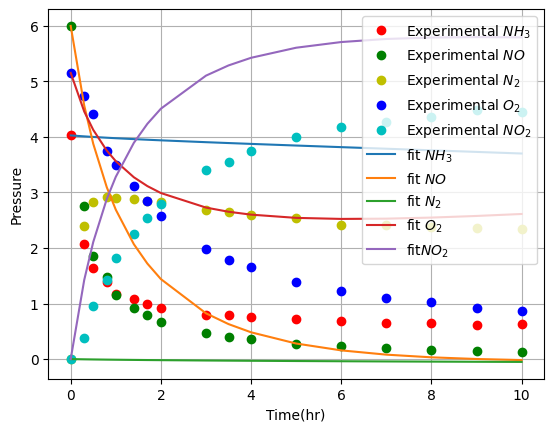

In [ ]:
plt.plot(data_new[0], data_new[1], 'or', label="Experimental $NH_3$")
plt.plot(data_new[0], data_new[2], 'og', label="Experimental $NO$")
plt.plot(data_new[0], data_new[3], 'oy', label="Experimental $N_2$")
plt.plot(data_new[0], data_new[4], 'ob', label="Experimental $O_2$")
plt.plot(data_new[0], data_new[5], 'oc', label="Experimental $NO_2$")
plt.plot(data_new[0], Cfit[0], label="fit $NH_3$")
plt.plot(data_new[0], Cfit[1], label="fit $NO$")
plt.plot(data_new[0], Cfit[2], label="fit $N_2$")
plt.plot(data_new[0], Cfit[3], label="fit $O_2$")
plt.plot(data_new[0], Cfit[4], label="fit$NO_2$")

plt.xlabel("Time(hr)")
plt.ylabel("Pressure")
plt.legend()
plt.grid()
plt.show()

## Dhavall's Solution

In [ ]:
import numpy as np
from scipy.optimize import fsolve, minimize, curve_fit
from scipy.integrate import solve_ivp, solve_bvp
import pandas as pd
from matplotlib import pyplot as plt
import time
import heapq

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_df = pd.read_csv("kinetics_data.csv")
print(data_df)
data = (data_df.to_numpy()).T

    Time    NH3     NO     N2     O2    NO2
0    0.0  4.024  5.994  0.000  5.149  0.000
1    0.3  2.073  2.759  2.386  4.732  0.388
2    0.5  1.633  1.852  2.818  4.413  0.947
3    0.8  1.385  1.471  2.916  3.751  1.414
4    1.0  1.169  1.160  2.895  3.499  1.815
5    1.4  1.075  0.919  2.877  3.121  2.245
6    1.7  0.988  0.795  2.842  2.838  2.539
7    2.0  0.928  0.673  2.822  2.569  2.783
8    3.0  0.799  0.467  2.679  1.979  3.410
9    3.5  0.790  0.404  2.650  1.789  3.551
10   4.0  0.755  0.357  2.591  1.665  3.746
11   5.0  0.725  0.280  2.547  1.392  3.989
12   6.0  0.686  0.229  2.419  1.223  4.183
13   7.0  0.647  0.198  2.421  1.096  4.273
14   8.0  0.647  0.172  2.383  1.019  4.361
15   9.0  0.618  0.146  2.350  0.923  4.473
16  10.0  0.630  0.127  2.340  0.859  4.437


Reactions:

9/2* O2 + NH3 --> 3/2* H2O + NO2 , k2

2* NO --->  N2 + O2, k1

NH3 = A, NO = B, N2 = C, O2 = D, NO2 =E

Assuming Molecular reactions

In [ ]:
def Conc_func(t, k1, k2):
    def ODEs(t, C):
        Ca, Cb, Cc, Cd, Ce = C
        dCa = -k2*Ca*Cd**(9/2)
        dCb = -k1*Cb**2
        dCc =  k1*Cb**2
        dCd =  k1*Cb**2 - k2* Cd**(9/2)* Ca
        dCe =  k2*Ca*Cd**(9/2)
        return [dCa, dCb, dCc, dCd, dCe]
    C0 = [data[1,0], data[2,0], data[3,0], data[4,0], data[5,0]]
    t_span = (t[0], t[-1])
    sol = solve_ivp(ODEs, t_span, C0, t_eval = t)
    y_pred = sol.y.ravel()
    return y_pred

t_data = data[0]
y_data = data[1:].ravel()
params, _ = curve_fit(Conc_func, t_data, y_data, p0 = [0.5,1], bounds= ([0, 0],[float('Inf'), float('Inf')]))

In [ ]:
print(f"Thus the determined Parameters for Reactions are, k1 = {params[0]}, k2 = {params[1]}")

Thus the determined Parameters for Reactions are, k1 = 0.04583295487337562, k2 = 0.0017234373744818574
